In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import scib
import anndata 

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt


import seaborn as sns

import tissue.api as tissue

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [3]:
# user = "david.fischer"
# user = "ina"
user = "mayar.ali"

if user == "david.fischer":
    base_path_gcn = "/Users/david.fischer/phd/seafile/DavidFischer_notforFabian/tissue/grid_searches/schuerch/"
    base_path_mi = "/Users/david.fischer/phd/seafile/DavidFischer_notforFabian/tissue/grid_searches/schuerch/"
    base_path_reg = "/Users/david.fischer/phd/seafile/DavidFischer_notforFabian/tissue/grid_searches/schuerch/"
elif user == "ina":
    base_path_gcn = '../../results/GCN/schuerch/'
    base_path_reg = '../../results/REG/schuerch/'
    
elif user == "mayar.ali":
    base_path_gcn = "/home/iterm/mayar.ali/phd/projects/tissue/grid_searches/refactor/schuerch/"
    base_path_mi = "/home/iterm/mayar.ali/phd/projects/tissue/grid_searches/refactor/schuerch/"
    base_path_reg = "/home/iterm/mayar.ali/phd/projects/tissue/grid_searches/refactor/schuerch/"


# Overall

In [4]:
dir_figures="/storage/groups/ml01/workspace/mayar.ali/tissue/figures/schuerch/"

In [57]:
def get_cells_features(layer_name, interpreter):
    # get features of cells

    if layer_name == 'input':
        h = [interpreter.h[image_key] for image_key in interpreter.img_keys_test]
    else:
        acts = interpreter._get_node_embeddings(
        idx=interpreter.img_keys_test,
        layers=[layer_name]
        )
        h = acts[layer_name]
        
    cells = np.concatenate(h)
    cells = cells[:, cells.std(axis=0) > 0]
    cells = (cells - cells.mean(axis=0)) / cells.std(axis=0)

    images = np.concatenate([[id] * interpreter.h[id].shape[0] for id in interpreter.img_keys_test])

    adata_cells = anndata.AnnData(
        cells,
        obs=pd.DataFrame({
            "images": images,
        })
    )

    adata_cells.obs['images'] = adata_cells.obs['images'].astype('category')
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    adata_cells.obs['images_label'] = le.fit_transform(adata_cells.obs["images"])
    return adata_cells

In [71]:
def get_intergation_metrics(adata_cells, model, cvx):
    
    metrics = [model, cvx]
    from sklearn.linear_model import LogisticRegression
    logreg = LogisticRegression()
    logreg.fit(adata_cells.X, adata_cells.obs["images_label"])

    print(f"{layer_name=}")
    image_score = logreg.score(adata_cells.X, adata_cells.obs["images_label"])
    print(f'Images training score: {image_score}')
    metrics.append(image_score)



    from sklearn.metrics import explained_variance_score, r2_score

    explained_variance_score_images = explained_variance_score(adata_cells.obs["images_label"], 
                                                               logreg.predict(adata_cells.X))
    print(f'Variance explained - images : {explained_variance_score_images}')
    metrics.append(explained_variance_score_images)

    r2_score_images = r2_score(adata_cells.obs["images_label"], 
                               logreg.predict(adata_cells.X), 
                               multioutput='uniform_average')
    print(f'R2 score - images: {r2_score_images}')
    metrics.append(r2_score_images)
    
    n_neighbors=50
    sc.pp.neighbors(adata_cells, n_neighbors=n_neighbors)
    sc.tl.pca(adata_cells)

    label_key="images"
    graph_conn = scib.metrics.graph_connectivity(adata_cells, label_key=label_key)
    metrics.append(graph_conn)
    print(f'graph connectivity metric {layer_name} layer - {label_key} = {graph_conn}')

    label_key="images"
    ilisi = scib.metrics.ilisi_graph(adata_cells, batch_key=label_key)
    metrics.append(ilisi)
    print(f'ilisi graph  metric {layer_name} layer - {label_key} = {ilisi}')

    df = pd.DataFrame(columns=["model", "cv", "prediction_score", "variance_explained", 
                               "r2_score", "graph_connectivity", "ilisi"])
    df.loc[0] = metrics
    return df

#### GCN SS

In [51]:
container_gcnss = tissue.fits.GridSearchContainer(
    source_path={
        "2205191327_GCNSS_SPECTRAL_GROUP_STANDARD_schuerch_RADIUS_MULTITASK_best_model": base_path_gcn,
        
    },
    gs_ids=[
        "2205191327_GCNSS_SPECTRAL_GROUP_STANDARD_schuerch_RADIUS_MULTITASK_best_model",
    ]
)
container_gcnss.load_gs()

loaded 2205191327_GCNSS_SPECTRAL_GROUP_STANDARD_schuerch_RADIUS_MULTITASK_best_model: 1 runs with 3-fold cross validation


In [55]:
group_name="Group"
gs_id, model_id, cv = container_gcnss.get_best_model_id(partition_select='train')
container_gcnss.get_info(gs_id = gs_id, model_id=model_id, load_labels=[group_name])
print(model_id)
container_gcnss.runparams[gs_id][model_id]

gcnss_spectral_schuerch_Groupadam_lr2_dr1_drp1_l23_de2_wi2_lw1_lt1_bs2_md2_tk1_ck1_fsstandard_fe1_fpmean_mtsmall_nc1_ew1_nh1_ssmultitask


{'model_id': 'gcnss_spectral_schuerch_Groupadam_lr2_dr1_drp1_l23_de2_wi2_lw1_lt1_bs2_md2_tk1_ck1_fsstandard_fe1_fpmean_mtsmall_nc1_ew1_nh1_ssmultitask',
 'model_class': 'gcnss',
 'gs_id': '2205191327_gcnss_spectral_group_standard_schuerch_radius_multitask_best_model',
 'data_set': 'schuerch',
 'max_dist': 50,
 'target_label': 'Group',
 'graph_label_selection': ['Age',
  'DFS',
  'Diffuse',
  'Group',
  'Klintrup_Makinen',
  'Sex'],
 'graph_covar_selection': None,
 'node_feature_space_id': 'standard',
 'node_feature_transformation': 'standardize_globally',
 'optimizer': 'adam',
 'learning_rate': 0.005,
 'depth_feature_embedding': 1,
 'depth': 2,
 'activation': 'leakyrelu_0.1',
 'dropout_rate': 0.0,
 'dropout_rate_pooling': 0.0,
 'l2_reg': 0.001,
 'loss_weight_others': 0.0,
 'loss_weight_type': 0.0,
 'batch_size': 32,
 'aggregation': 'spectral',
 'aggregation_depth': 1,
 'final_pooling': 'mean',
 'depth_final_dense': 1,
 'multitask_setting': 'small',
 'n_clusters': 5,
 'entropy_weight': 

In [72]:
df_metrics = pd.DataFrame(columns=["model", "cv", "prediction_score", "variance_explained", "r2_score", "graph_connectivity", "ilisi"])
df_metrics

Empty DataFrame
Columns: [model, cv, prediction_score, variance_explained, r2_score, graph_connectivity, ilisi]
Index: []

In [73]:
models = {
    'input': 'input',
    'Layer_gcn_1': 'GCNSS'
}
for cvx in ['cv0', 'cv1', 'cv2']:
    print(cvx)
    interpreter = tissue.fits.InterpreterGraph(results_path=base_path_gcn + gs_id + "/results/", cv=cvx, model_id=model_id, model_class="GCNSS")
    interpreter.load_model()

    data_path="/storage/groups/ml01/workspace/mayar.ali/tissue/data/schuerch/"
    buffered_data_path="/storage/groups/ml01/workspace/mayar.ali/tissue/data/schuerch/refactored/buffer"
    interpreter.get_data_again(
        data_path=data_path,
    #     buffered_data_path=buffered_data_path,
    )

    for layer_name in ['input', 'Layer_gcn_1']:
        print(f"{layer_name=}")
        adata_cells = get_cells_features(layer_name=layer_name, interpreter=interpreter)
        df = get_intergation_metrics(adata_cells, models[layer_name], cvx)
        df_metrics = pd.concat([df_metrics, df], ignore_index=True)
    

cv0
/storage/groups/ml01/workspace/mayar.ali/tissue/data/schuerch/refactored/buffer//buffered_data_50_binary.pickle
Loading data from buffer
Loaded 140 images with complete data from 35 patients over 258385 cells with 57 cell features and 2 distinct celltypes.


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos


Whole dataset: 140 images from 35 patients.
Test dataset: 16 images from 4 patients.
Training dataset: 124 images from 31 patients.
Validation dataset: 0 images from 0 patients.

layer_name='input'


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


layer_name='input'
Images training score: 0.966763544228333
Variance explained - images : 0.9588100405625549
R2 score - images: 0.9588096672062413
         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


graph connectivity metric input layer - images = 0.9918789079429573
/tmp/lisi_wn0m448c/input.mtx /tmp/lisi_wn0m448c/
ilisi graph  metric input layer - images = 0.06643296477172633
layer_name='Layer_gcn_1'


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10962ba7c0>
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:

layer_name='Layer_gcn_1'
Images training score: 0.7055294731351069
Variance explained - images : 0.5657455033958712
R2 score - images: 0.5623275523895976
graph connectivity metric Layer_gcn_1 layer - images = 0.9098374651701853
/tmp/lisi_y4hvqzt4/input.mtx /tmp/lisi_y4hvqzt4/
ilisi graph  metric Layer_gcn_1 layer - images = 0.10655904006021366
cv1
/storage/groups/ml01/workspace/mayar.ali/tissue/data/schuerch/refactored/buffer//buffered_data_50_binary.pickle
Loading data from buffer
Loaded 140 images with complete data from 35 patients over 258385 cells with 57 cell features and 2 distinct celltypes.


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos


Whole dataset: 140 images from 35 patients.
Test dataset: 16 images from 4 patients.
Training dataset: 124 images from 31 patients.
Validation dataset: 0 images from 0 patients.

layer_name='input'


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


layer_name='input'
Images training score: 0.966763544228333
Variance explained - images : 0.9588100405625549
R2 score - images: 0.9588096672062413
         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


graph connectivity metric input layer - images = 0.9918789079429573
/tmp/lisi_likd8d2z/input.mtx /tmp/lisi_likd8d2z/
ilisi graph  metric input layer - images = 0.06643296477172633
layer_name='Layer_gcn_1'


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f108617c5e0>
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:

layer_name='Layer_gcn_1'
Images training score: 0.8199567777032566
Variance explained - images : 0.6713487473698709
R2 score - images: 0.6712166010720388
graph connectivity metric Layer_gcn_1 layer - images = 0.9268574050578318
/tmp/lisi_tnr_njg1/input.mtx /tmp/lisi_tnr_njg1/
ilisi graph  metric Layer_gcn_1 layer - images = 0.07071805853371978
cv2
/storage/groups/ml01/workspace/mayar.ali/tissue/data/schuerch/refactored/buffer//buffered_data_50_binary.pickle
Loading data from buffer
Loaded 140 images with complete data from 35 patients over 258385 cells with 57 cell features and 2 distinct celltypes.


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos


Whole dataset: 140 images from 35 patients.
Test dataset: 16 images from 4 patients.
Training dataset: 124 images from 31 patients.
Validation dataset: 0 images from 0 patients.

layer_name='input'


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


layer_name='input'
Images training score: 0.966763544228333
Variance explained - images : 0.9588100405625549
R2 score - images: 0.9588096672062413
         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


graph connectivity metric input layer - images = 0.9918789079429573
/tmp/lisi_sz3o9_xu/input.mtx /tmp/lisi_sz3o9_xu/
ilisi graph  metric input layer - images = 0.06643296477172633
layer_name='Layer_gcn_1'


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10d7c9dbe0>
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:

layer_name='Layer_gcn_1'
Images training score: 0.7557567627990163
Variance explained - images : 0.5238262440722461
R2 score - images: 0.5215594013573803
graph connectivity metric Layer_gcn_1 layer - images = 0.9175002230395871
/tmp/lisi_ebfpcto1/input.mtx /tmp/lisi_ebfpcto1/
ilisi graph  metric Layer_gcn_1 layer - images = 0.0794894625500748


In [74]:
df_metrics

model   cv  prediction_score  variance_explained  r2_score  \
0  input  cv0          0.966764            0.958810  0.958810   
1  GCNSS  cv0          0.705529            0.565746  0.562328   
2  input  cv1          0.966764            0.958810  0.958810   
3  GCNSS  cv1          0.819957            0.671349  0.671217   
4  input  cv2          0.966764            0.958810  0.958810   
5  GCNSS  cv2          0.755757            0.523826  0.521559   

   graph_connectivity     ilisi  
0            0.991879  0.066433  
1            0.909837  0.106559  
2            0.991879  0.066433  
3            0.926857  0.070718  
4            0.991879  0.066433  
5            0.917500  0.079489

In [7]:
interpreter = tissue.fits.InterpreterGraph(results_path=base_path_gcn + gs_id + "/results/", cv=cv, model_id=model_id, model_class="GCNSS")
interpreter.load_model()

data_path="/storage/groups/ml01/workspace/mayar.ali/tissue/data/schuerch/"
buffered_data_path="/storage/groups/ml01/workspace/mayar.ali/tissue/data/schuerch/refactored/buffer"
interpreter.get_data_again(
    data_path=data_path,
    buffered_data_path=buffered_data_path,
)

2022-06-02 09:44:07.159170: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-02 09:44:07.159270: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: supergpu05.scidom.de
2022-06-02 09:44:07.159281: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: supergpu05.scidom.de
2022-06-02 09:44:07.159415: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.57.2
2022-06-02 09:44:07.159467: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.57.2
2022-06-02 09:44:07.159474: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.57.2
2022-06-02 09:44:07.160261: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the follow

/storage/groups/ml01/workspace/mayar.ali/tissue/data/schuerch/refactored/buffer//buffered_data_50_binary.pickle
Loading data from buffer
Loaded 140 images with complete data from 35 patients over 258385 cells with 57 cell features and 2 distinct celltypes.


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos


Whole dataset: 140 images from 35 patients.
Test dataset: 16 images from 4 patients.
Training dataset: 124 images from 31 patients.
Validation dataset: 0 images from 0 patients.



/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f7d6c552280>
/home/iterm/mayar.ali/phd/projects/tissue/tissue/interpretation/interpreter.py:371: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  labels = list(np.array(labels)[[[l in label_names for l in labels]]])


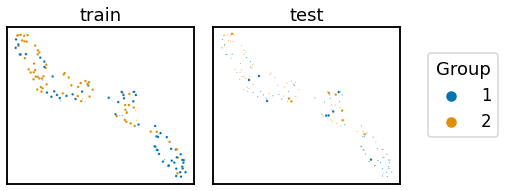

In [8]:
interpreter.plot_umap_graphs(
    label='Group',
    data_key='sch',
#     save='fig3c_refactored'
)

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f7d72bc5fa0>
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f7d5565abe0>


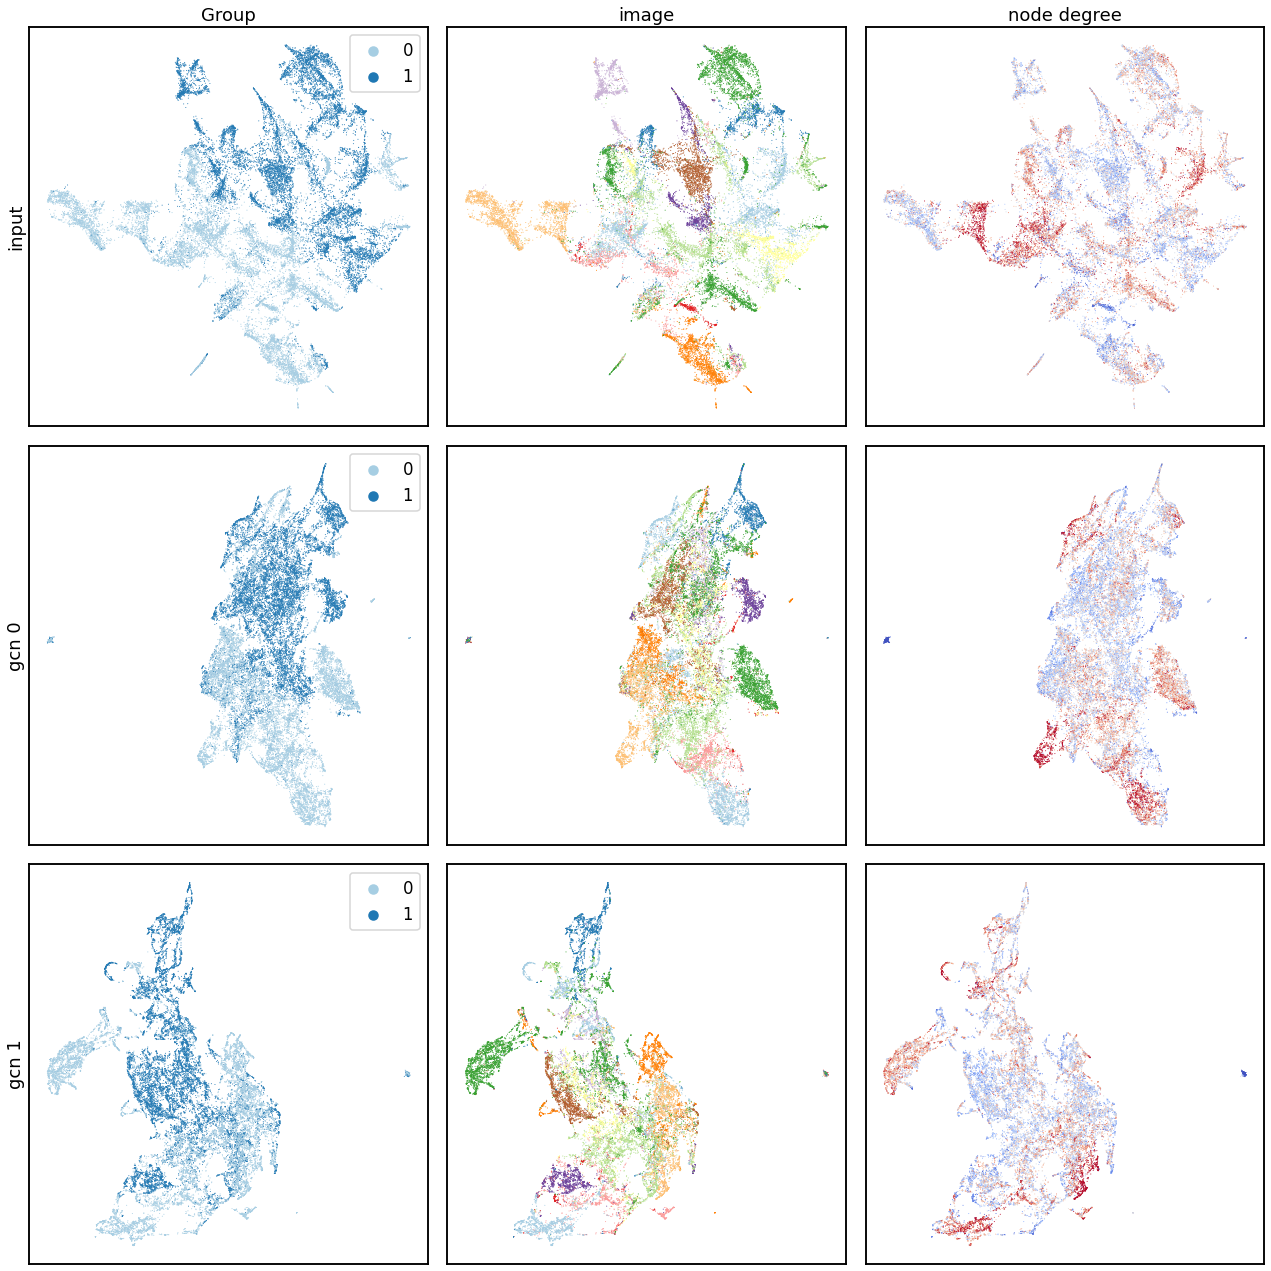

In [9]:
interpreter.plot_umap_nodes(
    interpreter.img_keys_test,
    plot_types = ['Group', 'images', 'degree'],
    layer_names=[
        'input',
        'Layer_gcn_0',
        'Layer_gcn_1',
    ],
    panel_width=6.0,
    panel_height=6.0,
    data_key='sch',
#     save=dir_figures+"supp_gcnss_std_node_emb_refactored", 
)

In [8]:
# get features of cells

layer_name = 'input'
h = [interpreter.h[image_key] for image_key in interpreter.img_keys_test]

cells = np.concatenate(h)
cells = cells[:, cells.std(axis=0) > 0]
cells = (cells - cells.mean(axis=0)) / cells.std(axis=0)

images = np.concatenate([[id] * interpreter.h[id].shape[0] for id in interpreter.img_keys_test])

adata_cells = anndata.AnnData(
    cells,
    obs=pd.DataFrame({
        "images": images,
    })
)

adata_cells.obs['images'] = adata_cells.obs['images'].astype('category')
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
adata_cells.obs['images_label'] = le.fit_transform(adata_cells.obs["images"])

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [9]:
predict_score_images_cells = []

varian_explained_images_cells = []
r2_images_cells = []
r2_linreg_images_cells = []

In [10]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(adata_cells.X, adata_cells.obs["images_label"])

print(f"{layer_name=}")
image_score = logreg.score(adata_cells.X, adata_cells.obs["images_label"])
print(f'Images training score: {image_score}')
predict_score_images_cells.append(image_score)



from sklearn.metrics import explained_variance_score, r2_score

explained_variance_score_images = explained_variance_score(adata_cells.obs["images_label"], 
                                                           logreg.predict(adata_cells.X))
print(f'Variance explained - images : {explained_variance_score_images}')
varian_explained_images_cells.append(explained_variance_score_images)

r2_score_images = r2_score(adata_cells.obs["images_label"], 
                           logreg.predict(adata_cells.X), 
                           multioutput='uniform_average')
print(f'R2 score - images: {r2_score_images}')
r2_images_cells.append(r2_score_images)

from scipy import sparse, stats

r2_score_linreg = stats.linregress(adata_cells.obs["images_label"], logreg.predict(adata_cells.X))[2] ** 2
print(f'R2 score linreg - images: {r2_score_linreg}')
r2_linreg_images_cells.append(r2_score_linreg)

layer_name='input'
Images training score: 0.966763544228333
Variance explained - images : 0.9588100405625549
R2 score - images: 0.9588096672062413
R2 score linreg - images: 0.9592674394857225


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
graph_connectivity_cells_images = []
ilisi_cells_images = []

In [12]:
n_neighbors=50
sc.pp.neighbors(adata_cells, n_neighbors=n_neighbors)
sc.tl.pca(adata_cells)

label_key="images"
images_metric = scib.metrics.graph_connectivity(adata_cells, label_key=label_key)
graph_connectivity_cells_images.append(images_metric)
print(f'graph connectivity metric {layer_name} layer - {label_key} = {images_metric}')

label_key="images"
images_metric = scib.metrics.ilisi_graph(adata_cells, batch_key=label_key)
ilisi_cells_images.append(images_metric)
print(f'ilisi graph  metric {layer_name} layer - {label_key} = {images_metric}')

         Falling back to preprocessing with `sc.pp.pca` and default params.
graph connectivity metric input layer - images = 0.9918789079429573
/tmp/lisi_gb7yfw9x/input.mtx /tmp/lisi_gb7yfw9x/
ilisi graph  metric input layer - images = 0.06643296477172633


In [13]:
layer_name = 'Layer_gcn_1'
acts = interpreter._get_node_embeddings(
        idx=interpreter.img_keys_test,
        layers=[layer_name]
    )
h = acts[layer_name]
cells = np.concatenate(h)
cells = cells[:, cells.std(axis=0) > 0]
cells = (cells - cells.mean(axis=0)) / cells.std(axis=0)


images = np.concatenate([[id] * interpreter.h[id].shape[0] for id in interpreter.img_keys_test])

adata_cells = anndata.AnnData(
    cells,
    obs=pd.DataFrame({
        "images": images,
    })
)

adata_cells.obs['images'] = adata_cells.obs['images'].astype('category')
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
adata_cells.obs['images_label'] = le.fit_transform(adata_cells.obs["images"])


from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(adata_cells.X, adata_cells.obs["images_label"])

print(f"{layer_name=}")
image_score = logreg.score(adata_cells.X, adata_cells.obs["images_label"])
print(f'Images training score: {image_score}')
predict_score_images_cells.append(image_score)



from sklearn.metrics import explained_variance_score, r2_score

explained_variance_score_images = explained_variance_score(adata_cells.obs["images_label"], 
                                                           logreg.predict(adata_cells.X))
print(f'Variance explained - images : {explained_variance_score_images}')
varian_explained_images_cells.append(explained_variance_score_images)

r2_score_images = r2_score(adata_cells.obs["images_label"], 
                           logreg.predict(adata_cells.X), 
                           multioutput='uniform_average')
print(f'R2 score - images: {r2_score_images}')
r2_images_cells.append(r2_score_images)

from scipy import sparse, stats

r2_score_linreg = stats.linregress(adata_cells.obs["images_label"], logreg.predict(adata_cells.X))[2] ** 2
print(f'R2 score linreg - images: {r2_score_linreg}')
r2_linreg_images_cells.append(r2_score_linreg)

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10e040e760>
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


layer_name='Layer_gcn_1'
Images training score: 0.8202548625083836
Variance explained - images : 0.6712589146548356
R2 score - images: 0.671132877262788
R2 score linreg - images: 0.7035228999074079


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
sc.pp.neighbors(adata_cells, n_neighbors=n_neighbors)
sc.tl.pca(adata_cells)

label_key="images"
images_metric = scib.metrics.graph_connectivity(adata_cells, label_key=label_key)
graph_connectivity_cells_images.append(images_metric)
print(f'graph connectivity metric {layer_name} layer - {label_key} = {images_metric}')

label_key="images"
images_metric = scib.metrics.ilisi_graph(adata_cells, batch_key=label_key)
ilisi_cells_images.append(images_metric)
print(f'ilisi graph  metric {layer_name} layer - {label_key} = {images_metric}')

graph connectivity metric Layer_gcn_1 layer - images = 0.928107938250691
/tmp/lisi_3eilj7gw/input.mtx /tmp/lisi_3eilj7gw/
ilisi graph  metric Layer_gcn_1 layer - images = 0.07206686015528448


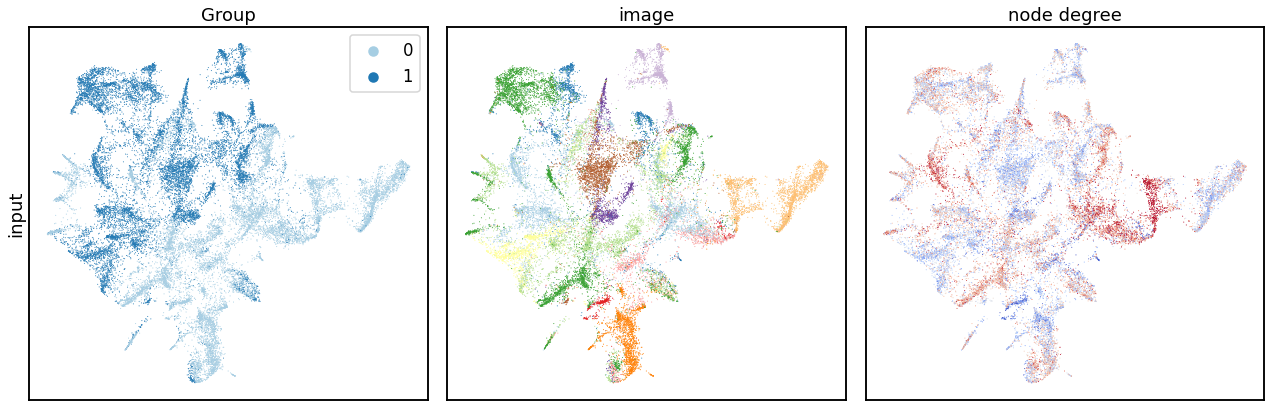

In [15]:
n_neighbors=50
layer_name = 'input'
umap_emb, hue = interpreter.plot_umap_nodes(
    interpreter.img_keys_test,
    plot_types = ['Group', 'images', 'degree'],
    layer_names=[
        layer_name,
    ],
    panel_width=6.0,
    panel_height=6.0,
    data_key='sch',
    return_embeddings=True,
    n_neighbors=n_neighbors,
)

In [16]:
adata = anndata.AnnData(
    umap_emb,
    obs=pd.DataFrame({
        "images": hue["images"],
        "Group": hue["Group"]
    })
)

adata.obs['images'] = adata.obs['images'].astype('category')
adata.obs['Group'] = adata.obs['Group'].astype('category')
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
adata.obs['images_label'] = le.fit_transform(adata.obs["images"])



sc.pp.neighbors(adata, n_neighbors=n_neighbors)
sc.tl.pca(adata)

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [17]:
predict_score_images = []
predict_score_grade = []

varian_explained_images = []
r2_images = []
r2_linreg_images = []

In [18]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(adata.X, adata.obs["images_label"])

print(f"{layer_name=}")
image_score = logreg.score(adata.X, adata.obs["images_label"])
print(f'Images training score: {image_score}')
predict_score_images.append(image_score)


from sklearn.linear_model import LogisticRegression
logreg_grade = LogisticRegression()
logreg_grade.fit(adata.X, adata.obs["Group"])

grade_score = logreg_grade.score(adata.X, adata.obs["Group"])
print(f'Group training score: {grade_score}')
predict_score_grade.append(grade_score)


from sklearn.metrics import explained_variance_score, r2_score

explained_variance_score_images = explained_variance_score(adata.obs["images_label"], logreg.predict(adata.X), multioutput='variance_weighted')
print(f'Variance explained - images : {explained_variance_score_images}')
varian_explained_images.append(explained_variance_score_images)

r2_score_images = r2_score(adata.obs["images_label"], logreg.predict(adata.X), multioutput='uniform_average')
print(f'R2 score - images: {r2_score_images}')
r2_images.append(r2_score_images)

from scipy import sparse, stats

r2_score_linreg = stats.linregress(adata.obs["images_label"], logreg.predict(adata.X))[2] ** 2
print(f'R2 score linreg - images: {r2_score_linreg}')
r2_linreg_images.append(r2_score_linreg)

layer_name='input'
Images training score: 0.5023101572397347
Group training score: 0.8626946866383486
Variance explained - images : 0.41418895170295594
R2 score - images: 0.40975961428524044
R2 score linreg - images: 0.5051689872477058


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [19]:
graph_conn_grade = []
ilsi_graph_grade = []

graph_conn_images = []
ilsi_graph_images = []

In [20]:
### n=50
label_key="Group"
graph_metric = scib.metrics.graph_connectivity(adata, label_key=label_key)
graph_conn_grade.append(graph_metric)

print(f'graph connectivity metric {layer_name} layer - {label_key} = {graph_metric}')

label_key="images"
images_metric = scib.metrics.graph_connectivity(adata, label_key=label_key)
graph_conn_images.append(images_metric)
print(f'graph connectivity metric {layer_name} layer - {label_key} = {images_metric}')

label_key="Group"
grade_metric = scib.metrics.ilisi_graph(adata, batch_key=label_key)
ilsi_graph_grade.append(grade_metric)
print(f'ilisi graph metric {layer_name} layer - {label_key} = {grade_metric}')

label_key="images"
images_metric = scib.metrics.ilisi_graph(adata, batch_key=label_key)
ilsi_graph_images.append(images_metric)
print(f'ilisi graph  metric {layer_name} layer - {label_key} = {images_metric}')

graph connectivity metric input layer - Group = 0.9226315357079045
graph connectivity metric input layer - images = 0.6934799155298756
/tmp/lisi_7s90ns13/input.mtx /tmp/lisi_7s90ns13/
ilisi graph metric input layer - Group = 0.039727845535989736
/tmp/lisi__6nb7w5y/input.mtx /tmp/lisi__6nb7w5y/
ilisi graph  metric input layer - images = 0.02267718873558812


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10e121d9a0>


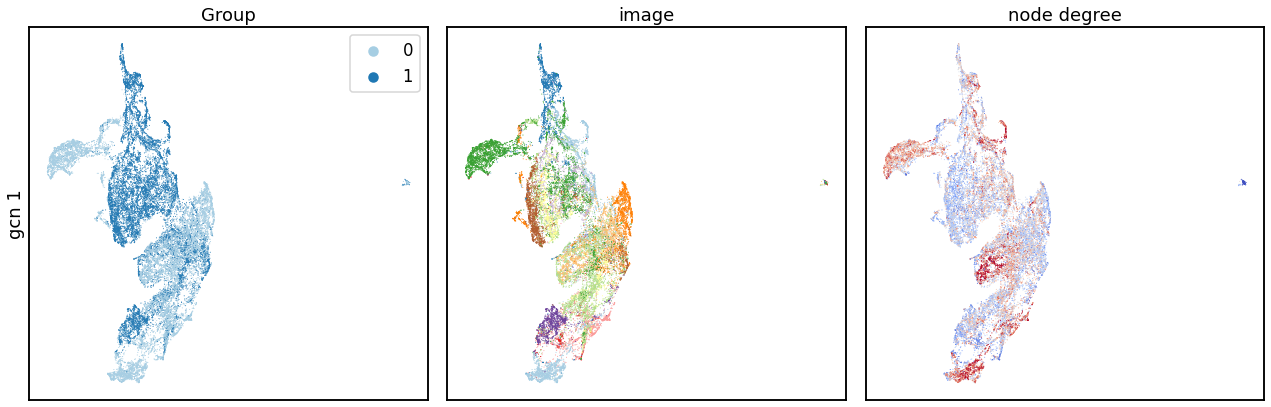

In [21]:
n_neighbors=50
layer_name = 'Layer_gcn_1'
umap_emb, hue = interpreter.plot_umap_nodes(
    interpreter.img_keys_test,
    plot_types = ['Group', 'images', 'degree'],
    layer_names=[
        layer_name,
    ],
    panel_width=6.0,
    panel_height=6.0,
    data_key='sch',
    return_embeddings=True,
    n_neighbors=n_neighbors,
)

In [22]:
adata = anndata.AnnData(
    umap_emb,
    obs=pd.DataFrame({
        "images": hue["images"],
        "Group": hue["Group"]
    })
)

adata.obs['images'] = adata.obs['images'].astype('category')
adata.obs['Group'] = adata.obs['Group'].astype('category')
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
adata.obs['images_label'] = le.fit_transform(adata.obs["images"])


sc.pp.neighbors(adata, n_neighbors=n_neighbors)
sc.tl.pca(adata)

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [23]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(adata.X, adata.obs["images_label"])

print(f"{layer_name=}")
image_score = logreg.score(adata.X, adata.obs["images_label"])
print(f'Images training score: {image_score}')
predict_score_images.append(image_score)


from sklearn.linear_model import LogisticRegression
logreg_grade = LogisticRegression()
logreg_grade.fit(adata.X, adata.obs["Group"])

grade_score = logreg_grade.score(adata.X, adata.obs["Group"])
print(f'Group training score: {grade_score}')
predict_score_grade.append(grade_score)


from sklearn.metrics import explained_variance_score, r2_score

explained_variance_score_images = explained_variance_score(adata.obs["images_label"], logreg.predict(adata.X), multioutput='variance_weighted')
print(f'Variance explained - images : {explained_variance_score_images}')
varian_explained_images.append(explained_variance_score_images)

r2_score_images = r2_score(adata.obs["images_label"], logreg.predict(adata.X), multioutput='uniform_average')
print(f'R2 score - images: {r2_score_images}')
r2_images.append(r2_score_images)

from scipy import sparse, stats

r2_score_linreg = stats.linregress(adata.obs["images_label"], logreg.predict(adata.X))[2] ** 2
print(f'R2 score linreg - images: {r2_score_linreg}')
r2_linreg_images.append(r2_score_linreg)

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


layer_name='Layer_gcn_1'
Images training score: 0.4525672553841568
Group training score: 0.6102913778970117
Variance explained - images : -0.12234838608342048
R2 score - images: -0.13932962850392028
R2 score linreg - images: 0.1759893847323155


In [24]:
### n=50
label_key="Group"
graph_metric = scib.metrics.graph_connectivity(adata, label_key=label_key)
graph_conn_grade.append(graph_metric)

print(f'graph connectivity metric {layer_name} layer - {label_key} = {graph_metric}')

label_key="images"
images_metric = scib.metrics.graph_connectivity(adata, label_key=label_key)
graph_conn_images.append(images_metric)
print(f'graph connectivity metric {layer_name} layer - {label_key} = {images_metric}')

label_key="Group"
grade_metric = scib.metrics.ilisi_graph(adata, batch_key=label_key)
ilsi_graph_grade.append(grade_metric)
print(f'ilisi graph metric {layer_name} layer - {label_key} = {grade_metric}')

label_key="images"
images_metric = scib.metrics.ilisi_graph(adata, batch_key=label_key)
ilsi_graph_images.append(images_metric)
print(f'ilisi graph  metric {layer_name} layer - {label_key} = {images_metric}')

graph connectivity metric Layer_gcn_1 layer - Group = 0.849874331123007
graph connectivity metric Layer_gcn_1 layer - images = 0.7356432106676769
/tmp/lisi_x67oyxzz/input.mtx /tmp/lisi_x67oyxzz/
ilisi graph metric Layer_gcn_1 layer - Group = 0.16885274678233464
/tmp/lisi_26p0jlvb/input.mtx /tmp/lisi_26p0jlvb/
ilisi graph  metric Layer_gcn_1 layer - images = 0.06938081182451494


#### GCN

In [85]:
container_gcn = tissue.fits.GridSearchContainer(
    source_path={
        "2205191325_GCN_NONE_GROUP_STANDARD_schuerch_RADIUS_NONE_best_model": base_path_gcn,
    },
    gs_ids=[
        "2205191325_GCN_NONE_GROUP_STANDARD_schuerch_RADIUS_NONE_best_model",
        
    ]
)
container_gcn.load_gs()

loaded 2205191325_GCN_NONE_GROUP_STANDARD_schuerch_RADIUS_NONE_best_model: 1 runs with 3-fold cross validation


In [86]:
gs_id, model_id, cv = container_gcn.get_best_model_id(partition_select='val')
container_gcn.get_info(gs_id = gs_id, model_id=model_id, load_labels=[group_name])
print(model_id)
container_gcn.runparams[gs_id][model_id]

gcn_none_schuerch_Groupadam_lr3_dr1_drp1_l22_de2_wi2_lw1_lt1_bs2_md2_tk1_ck1_fsstandard_fe1_fpmean_mtsmall_nc1_ew1_nh1_ssnone


{'model_id': 'gcn_none_schuerch_Groupadam_lr3_dr1_drp1_l22_de2_wi2_lw1_lt1_bs2_md2_tk1_ck1_fsstandard_fe1_fpmean_mtsmall_nc1_ew1_nh1_ssnone',
 'model_class': 'gcn',
 'gs_id': '2205191325_gcn_none_group_standard_schuerch_radius_none_best_model',
 'data_set': 'schuerch',
 'max_dist': 50,
 'target_label': 'Group',
 'graph_label_selection': ['Age',
  'DFS',
  'Diffuse',
  'Group',
  'Klintrup_Makinen',
  'Sex'],
 'graph_covar_selection': None,
 'node_feature_space_id': 'standard',
 'node_feature_transformation': 'standardize_globally',
 'optimizer': 'adam',
 'learning_rate': 0.0005,
 'depth_feature_embedding': 1,
 'depth': 2,
 'activation': 'leakyrelu_0.1',
 'dropout_rate': 0.0,
 'dropout_rate_pooling': 0.0,
 'l2_reg': 1e-06,
 'loss_weight_others': 0.0,
 'loss_weight_type': 0.0,
 'batch_size': 32,
 'aggregation': 'none',
 'aggregation_depth': 1,
 'final_pooling': 'mean',
 'depth_final_dense': 1,
 'multitask_setting': 'small',
 'n_clusters': 5,
 'entropy_weight': 0.0001,
 'number_heads': 1,

In [87]:
for cvx in ['cv0', 'cv1', 'cv2']:
    print(cvx)
    interpreter = tissue.fits.InterpreterGraph(results_path=base_path_gcn + gs_id + "/results/", cv=cvx, model_id=model_id, model_class="GCN")
    interpreter.load_model()

    data_path="/storage/groups/ml01/workspace/mayar.ali/tissue/data/schuerch/"
    buffered_data_path="/storage/groups/ml01/workspace/mayar.ali/tissue/data/schuerch/refactored/buffer"
    interpreter.get_data_again(
        data_path=data_path,
        bufffered_data_path=buffered_data_path,
    )

    layer_name='Layer_gcn_1'
    print(f"{layer_name=}")
    adata_cells = get_cells_features(layer_name=layer_name, interpreter=interpreter)
    df = get_intergation_metrics(adata_cells, "GCN", cvx)
    df_metrics = pd.concat([df_metrics, df], ignore_index=True)
    

cv0
/storage/groups/ml01/workspace/mayar.ali/tissue/data/schuerch/refactored/buffer//buffered_data_50_binary.pickle
Loading data from buffer
Loaded 140 images with complete data from 35 patients over 258385 cells with 57 cell features and 2 distinct celltypes.

Whole dataset: 140 images from 35 patients.
Test dataset: 16 images from 4 patients.
Training dataset: 124 images from 31 patients.
Validation dataset: 0 images from 0 patients.

layer_name='Layer_gcn_1'


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10d77f8040>
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:

layer_name='Layer_gcn_1'
Images training score: 0.7892540427751695
Variance explained - images : 0.6531109470954797
R2 score - images: 0.6530930684057021
graph connectivity metric Layer_gcn_1 layer - images = 0.911555975414531
/tmp/lisi_o17wg2ps/input.mtx /tmp/lisi_o17wg2ps/


ilisi graph  metric Layer_gcn_1 layer - images = 0.072905413649434
cv1
/storage/groups/ml01/workspace/mayar.ali/tissue/data/schuerch/refactored/buffer//buffered_data_50_binary.pickle
Loading data from buffer
Loaded 140 images with complete data from 35 patients over 258385 cells with 57 cell features and 2 distinct celltypes.

Whole dataset: 140 images from 35 patients.
Test dataset: 16 images from 4 patients.
Training dataset: 124 images from 31 patients.
Validation dataset: 0 images from 0 patients.

layer_name='Layer_gcn_1'


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f1088eb0a60>
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:

layer_name='Layer_gcn_1'
Images training score: 0.7946195692674566
Variance explained - images : 0.7323328871136865
R2 score - images: 0.7322352257970922
graph connectivity metric Layer_gcn_1 layer - images = 0.9151980943972124
/tmp/lisi_1bbqv2yd/input.mtx /tmp/lisi_1bbqv2yd/
ilisi graph  metric Layer_gcn_1 layer - images = 0.05916521676811171
cv2
/storage/groups/ml01/workspace/mayar.ali/tissue/data/schuerch/refactored/buffer//buffered_data_50_binary.pickle
Loading data from buffer
Loaded 140 images with complete data from 35 patients over 258385 cells with 57 cell features and 2 distinct celltypes.

Whole dataset: 140 images from 35 patients.
Test dataset: 16 images from 4 patients.
Training dataset: 124 images from 31 patients.
Validation dataset: 0 images from 0 patients.

layer_name='Layer_gcn_1'


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f108fb1e220>
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:

layer_name='Layer_gcn_1'
Images training score: 0.793874357254639
Variance explained - images : 0.602026012360946
R2 score - images: 0.6008209097108939
graph connectivity metric Layer_gcn_1 layer - images = 0.922534307377843
/tmp/lisi_lew9ctka/input.mtx /tmp/lisi_lew9ctka/
ilisi graph  metric Layer_gcn_1 layer - images = 0.05727577639889928


In [27]:
interpreter_gcn = tissue.fits.InterpreterGraph(results_path=base_path_gcn + gs_id + "/results/", cv=cv, model_id=model_id, model_class="GCN")
interpreter_gcn.load_model()
interpreter_gcn.get_data_again(
    data_path=data_path,
)

/storage/groups/ml01/workspace/mayar.ali/tissue/data/schuerch/refactored/buffer//buffered_data_50_binary.pickle
Loading data from buffer
Loaded 140 images with complete data from 35 patients over 258385 cells with 57 cell features and 2 distinct celltypes.

Whole dataset: 140 images from 35 patients.
Test dataset: 16 images from 4 patients.
Training dataset: 124 images from 31 patients.
Validation dataset: 0 images from 0 patients.



/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f7d68c11dc0>
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f7d0488e400>


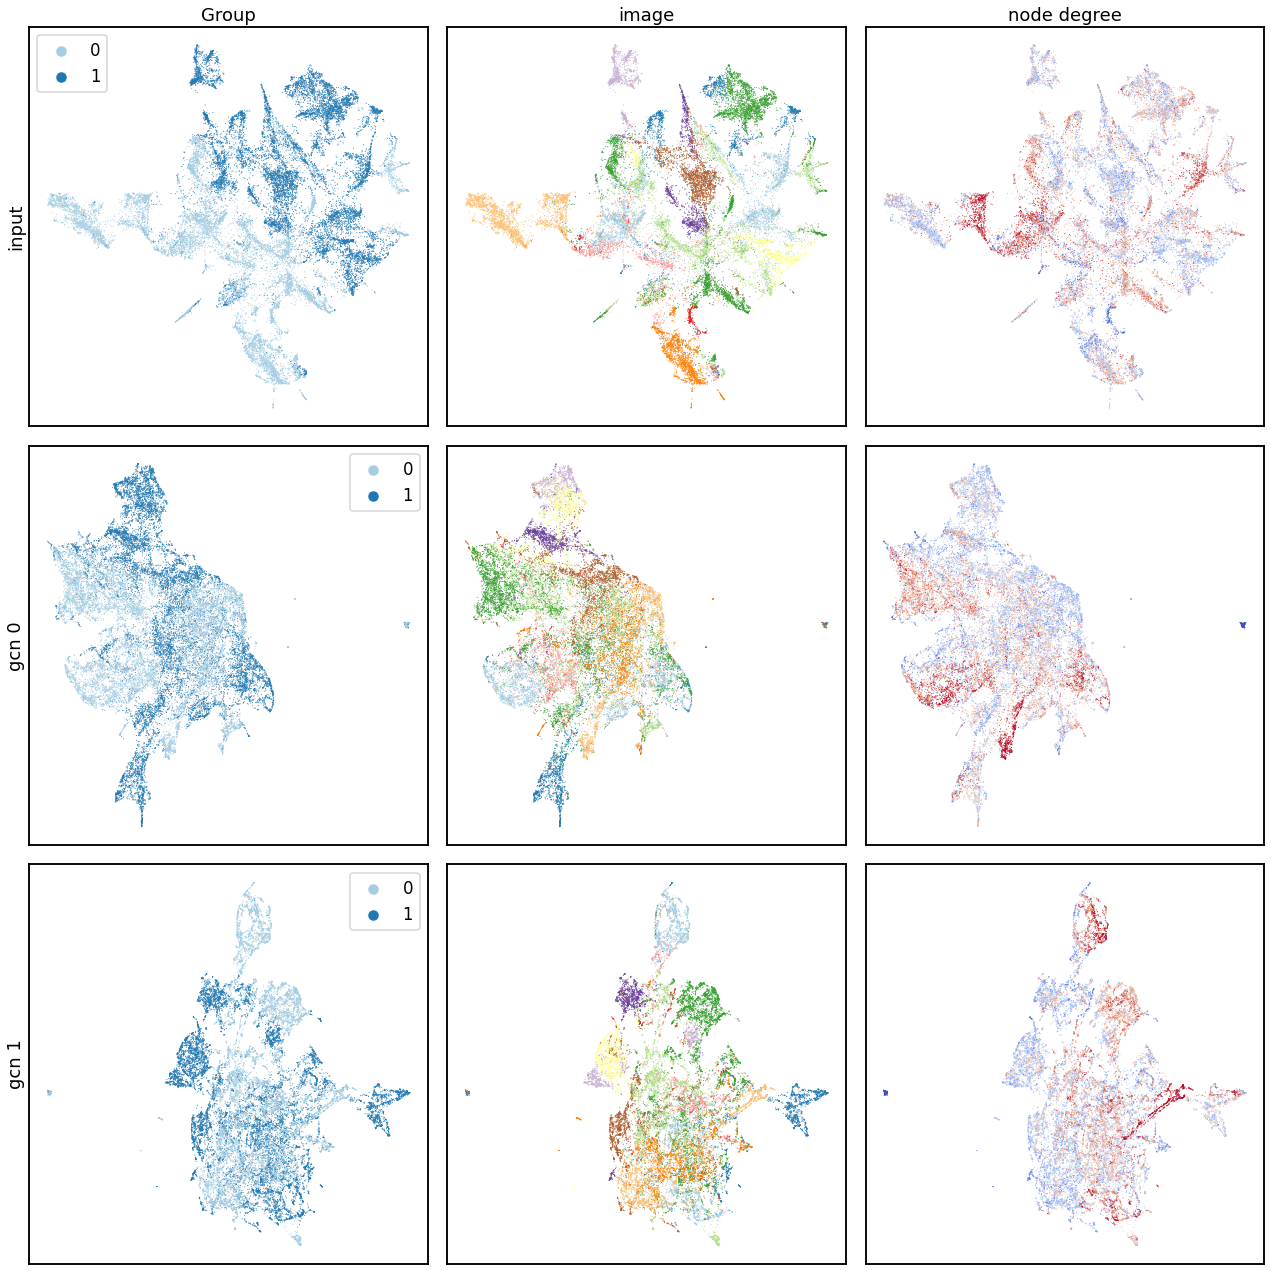

In [32]:
interpreter_gcn.plot_umap_nodes(
    interpreter_gcn.img_keys_test,
    plot_types = ['Group', 'images', 'degree'],
    layer_names=[
        'input',
        'Layer_gcn_0',
        'Layer_gcn_1',
    ],
    panel_width=6.0,
    panel_height=6.0,
    data_key='sch',
#     save=dir_figures+"supp_gcn_std_node_emb_refactored", 
)

In [28]:
layer_name = 'Layer_gcn_1'
acts = interpreter_gcn._get_node_embeddings(
        idx=interpreter_gcn.img_keys_test,
        layers=[layer_name]
    )
h = acts[layer_name]
cells = np.concatenate(h)
cells = cells[:, cells.std(axis=0) > 0]
cells = (cells - cells.mean(axis=0)) / cells.std(axis=0)


images = np.concatenate([[id] * interpreter_gcn.h[id].shape[0] for id in interpreter_gcn.img_keys_test])

adata_cells = anndata.AnnData(
    cells,
    obs=pd.DataFrame({
        "images": images,
    })
)

adata_cells.obs['images'] = adata_cells.obs['images'].astype('category')
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
adata_cells.obs['images_label'] = le.fit_transform(adata_cells.obs["images"])


from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(adata_cells.X, adata_cells.obs["images_label"])

print(f"{layer_name=}")
image_score = logreg.score(adata_cells.X, adata_cells.obs["images_label"])
print(f'Images training score: {image_score}')
predict_score_images_cells.append(image_score)



from sklearn.metrics import explained_variance_score, r2_score

explained_variance_score_images = explained_variance_score(adata_cells.obs["images_label"], 
                                                           logreg.predict(adata_cells.X))
print(f'Variance explained - images : {explained_variance_score_images}')
varian_explained_images_cells.append(explained_variance_score_images)

r2_score_images = r2_score(adata_cells.obs["images_label"], 
                           logreg.predict(adata_cells.X), 
                           multioutput='uniform_average')
print(f'R2 score - images: {r2_score_images}')
r2_images_cells.append(r2_score_images)

from scipy import sparse, stats

r2_score_linreg = stats.linregress(adata_cells.obs["images_label"], logreg.predict(adata_cells.X))[2] ** 2
print(f'R2 score linreg - images: {r2_score_linreg}')
r2_linreg_images_cells.append(r2_score_linreg)

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10d2347400>
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


layer_name='Layer_gcn_1'
Images training score: 0.7892540427751695
Variance explained - images : 0.6531109470954797
R2 score - images: 0.6530930684057021
R2 score linreg - images: 0.6861133505969441


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [29]:
sc.pp.neighbors(adata_cells, n_neighbors=n_neighbors)
sc.tl.pca(adata_cells)

label_key="images"
images_metric = scib.metrics.graph_connectivity(adata_cells, label_key=label_key)
graph_connectivity_cells_images.append(images_metric)
print(f'graph connectivity metric {layer_name} layer - {label_key} = {images_metric}')

label_key="images"
images_metric = scib.metrics.ilisi_graph(adata_cells, batch_key=label_key)
ilisi_cells_images.append(images_metric)
print(f'ilisi graph  metric {layer_name} layer - {label_key} = {images_metric}')

graph connectivity metric Layer_gcn_1 layer - images = 0.911555975414531
/tmp/lisi_91xxv3g0/input.mtx /tmp/lisi_91xxv3g0/
ilisi graph  metric Layer_gcn_1 layer - images = 0.072905413649434


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10d33140a0>


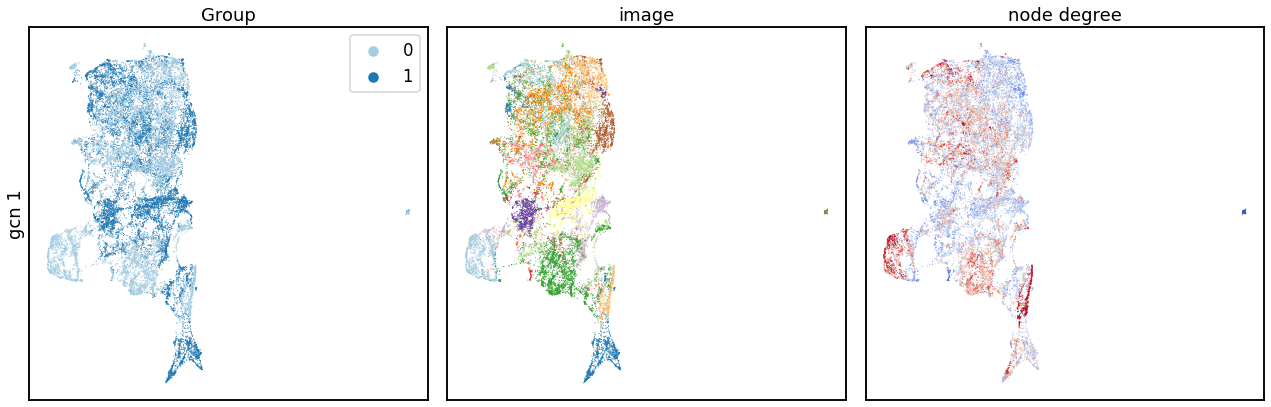

In [30]:
n_neighbors=50
layer_name = 'Layer_gcn_1'
umap_emb, hue = interpreter_gcn.plot_umap_nodes(
    interpreter.img_keys_test,
    plot_types = ['Group', 'images', 'degree'],
    layer_names=[
        layer_name,
    ],
    panel_width=6.0,
    panel_height=6.0,
    data_key='sch',
    return_embeddings=True,
    n_neighbors=n_neighbors,
)

In [31]:
adata = anndata.AnnData(
    umap_emb,
    obs=pd.DataFrame({
        "images": hue["images"],
        "Group": hue["Group"]
    })
)

adata.obs['images'] = adata.obs['images'].astype('category')
adata.obs['Group'] = adata.obs['Group'].astype('category')
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
adata.obs['images_label'] = le.fit_transform(adata.obs["images"])


sc.pp.neighbors(adata, n_neighbors=n_neighbors)
sc.tl.pca(adata)

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [32]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(adata.X, adata.obs["images_label"])

print(f"{layer_name=}")
image_score = logreg.score(adata.X, adata.obs["images_label"])
print(f'Images training score: {image_score}')
predict_score_images.append(image_score)


from sklearn.linear_model import LogisticRegression
logreg_grade = LogisticRegression()
logreg_grade.fit(adata.X, adata.obs["Group"])

grade_score = logreg_grade.score(adata.X, adata.obs["Group"])
print(f'Group training score: {grade_score}')
predict_score_grade.append(grade_score)


from sklearn.metrics import explained_variance_score, r2_score

explained_variance_score_images = explained_variance_score(adata.obs["images_label"], logreg.predict(adata.X), multioutput='variance_weighted')
print(f'Variance explained - images : {explained_variance_score_images}')
varian_explained_images.append(explained_variance_score_images)

r2_score_images = r2_score(adata.obs["images_label"], logreg.predict(adata.X), multioutput='uniform_average')
print(f'R2 score - images: {r2_score_images}')
r2_images.append(r2_score_images)

from scipy import sparse, stats

r2_score_linreg = stats.linregress(adata.obs["images_label"], logreg.predict(adata.X))[2] ** 2
print(f'R2 score linreg - images: {r2_score_linreg}')
r2_linreg_images.append(r2_score_linreg)

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


layer_name='Layer_gcn_1'
Images training score: 0.3063566584693345
Group training score: 0.5768313585214994
Variance explained - images : -1.1075553135318703
R2 score - images: -1.1888129215358516
R2 score linreg - images: 0.033038971622944495


In [33]:
### n=50
label_key="Group"
graph_metric = scib.metrics.graph_connectivity(adata, label_key=label_key)
graph_conn_grade.append(graph_metric)

print(f'graph connectivity metric {layer_name} layer - {label_key} = {graph_metric}')

label_key="images"
images_metric = scib.metrics.graph_connectivity(adata, label_key=label_key)
graph_conn_images.append(images_metric)
print(f'graph connectivity metric {layer_name} layer - {label_key} = {images_metric}')

label_key="Group"
grade_metric = scib.metrics.ilisi_graph(adata, batch_key=label_key)
ilsi_graph_grade.append(grade_metric)
print(f'ilisi graph metric {layer_name} layer - {label_key} = {grade_metric}')

label_key="images"
images_metric = scib.metrics.ilisi_graph(adata, batch_key=label_key)
ilsi_graph_images.append(images_metric)
print(f'ilisi graph  metric {layer_name} layer - {label_key} = {images_metric}')

graph connectivity metric Layer_gcn_1 layer - Group = 0.9777711615909315
graph connectivity metric Layer_gcn_1 layer - images = 0.7067800341102767
/tmp/lisi_0ftiog6r/input.mtx /tmp/lisi_0ftiog6r/
ilisi graph metric Layer_gcn_1 layer - Group = 0.3698424691970854
/tmp/lisi_pbluipfd/input.mtx /tmp/lisi_pbluipfd/
ilisi graph  metric Layer_gcn_1 layer - images = 0.06792554125349497


#### MI

In [88]:
container_mi = tissue.fits.GridSearchContainer(
    source_path={
        "2205191328_MI_NONE_GRADE_STANDARD_schuerch_RADIUS_NONE_best_model": base_path_gcn,
    },
    gs_ids=[
        "2205191328_MI_NONE_GRADE_STANDARD_schuerch_RADIUS_NONE_best_model",

    ]
)
container_mi.load_gs()

loaded 2205191328_MI_NONE_GRADE_STANDARD_schuerch_RADIUS_NONE_best_model: 1 runs with 3-fold cross validation


In [89]:
gs_id, model_id, cv = container_mi.get_best_model_id(partition_select='train')
container_mi.get_info(gs_id = gs_id, model_id=model_id, load_labels=[group_name])

mi_none_schuerch_Groupadam_lr2_dr1_drp1_l23_de1_wi1_lw1_lt1_bs2_md1_tk1_ck1_fsstandard_fe0_fpmean_mtsmall_nc2_ew1_nh1_ssnone


{'model_id': 'mi_none_schuerch_Groupadam_lr2_dr1_drp1_l23_de1_wi1_lw1_lt1_bs2_md1_tk1_ck1_fsstandard_fe0_fpmean_mtsmall_nc2_ew1_nh1_ssnone',
 'model_class': 'mi',
 'gs_id': '2205191328_mi_none_grade_standard_schuerch_radius_none_best_model',
 'data_set': 'schuerch',
 'max_dist': 25,
 'target_label': 'Group',
 'graph_label_selection': ['Age',
  'DFS',
  'Diffuse',
  'Group',
  'Klintrup_Makinen',
  'Sex'],
 'graph_covar_selection': None,
 'node_feature_space_id': 'standard',
 'node_feature_transformation': 'standardize_globally',
 'optimizer': 'adam',
 'learning_rate': 0.005,
 'depth_feature_embedding': 0,
 'depth': 1,
 'activation': 'leakyrelu_0.1',
 'dropout_rate': 0.0,
 'dropout_rate_pooling': 0.0,
 'l2_reg': 0.001,
 'loss_weight_others': 0.0,
 'loss_weight_type': 0.0,
 'batch_size': 32,
 'aggregation': 'none',
 'aggregation_depth': 1,
 'final_pooling': 'mean',
 'depth_final_dense': 1,
 'multitask_setting': 'small',
 'n_clusters': 10,
 'entropy_weight': 0.0001,
 'number_heads': 1,
 '

In [91]:
for cvx in ['cv0', 'cv1', 'cv2']:
    print(cvx)
    interpreter = tissue.fits.InterpreterNoGraph(results_path=base_path_gcn + gs_id + "/results/", cv=cv, model_id=model_id, model_class="MI")
    interpreter.load_model()

    data_path="/storage/groups/ml01/workspace/mayar.ali/tissue/data/schuerch/"
    buffered_data_path="/storage/groups/ml01/workspace/mayar.ali/tissue/data/schuerch/refactored/buffer/"
    interpreter.get_data_again(
        data_path=data_path,
    )

    layer_name='Layer_dense_feature_embedding0'
    print(f"{layer_name=}")
    adata_cells = get_cells_features(layer_name=layer_name, interpreter=interpreter)
    df = get_intergation_metrics(adata_cells, "MI", cvx)
    df_metrics = pd.concat([df_metrics, df], ignore_index=True)
    

cv0
/storage/groups/ml01/workspace/mayar.ali/tissue/data/schuerch/refactored/buffer//buffered_data_25_binary.pickle
Loading data from buffer
Loaded 140 images with complete data from 35 patients over 258385 cells with 57 cell features and 2 distinct celltypes.

Whole dataset: 140 images from 35 patients.
Test dataset: 16 images from 4 patients.
Training dataset: 124 images from 31 patients.
Validation dataset: 0 images from 0 patients.

layer_name='Layer_dense_feature_embedding0'


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


layer_name='Layer_dense_feature_embedding0'
Images training score: 0.37413369103509947
Variance explained - images : -0.19724004519156635
R2 score - images: -0.2288214738048262
graph connectivity metric Layer_dense_feature_embedding0 layer - images = 0.9346012782920832
/tmp/lisi_4njnkvns/input.mtx /tmp/lisi_4njnkvns/
ilisi graph  metric Layer_dense_feature_embedding0 layer - images = 0.19686109306937655
cv1
/storage/groups/ml01/workspace/mayar.ali/tissue/data/schuerch/refactored/buffer//buffered_data_25_binary.pickle
Loading data from buffer
Loaded 140 images with complete data from 35 patients over 258385 cells with 57 cell features and 2 distinct celltypes.

Whole dataset: 140 images from 35 patients.
Test dataset: 16 images from 4 patients.
Training dataset: 124 images from 31 patients.
Validation dataset: 0 images from 0 patients.

layer_name='Layer_dense_feature_embedding0'


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


layer_name='Layer_dense_feature_embedding0'
Images training score: 0.37413369103509947
Variance explained - images : -0.19724004519156635
R2 score - images: -0.2288214738048262
graph connectivity metric Layer_dense_feature_embedding0 layer - images = 0.9346012782920832
/tmp/lisi_wmt_keat/input.mtx /tmp/lisi_wmt_keat/
ilisi graph  metric Layer_dense_feature_embedding0 layer - images = 0.19686109306937655
cv2
/storage/groups/ml01/workspace/mayar.ali/tissue/data/schuerch/refactored/buffer//buffered_data_25_binary.pickle
Loading data from buffer
Loaded 140 images with complete data from 35 patients over 258385 cells with 57 cell features and 2 distinct celltypes.

Whole dataset: 140 images from 35 patients.
Test dataset: 16 images from 4 patients.
Training dataset: 124 images from 31 patients.
Validation dataset: 0 images from 0 patients.

layer_name='Layer_dense_feature_embedding0'


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


layer_name='Layer_dense_feature_embedding0'
Images training score: 0.37413369103509947
Variance explained - images : -0.19724004519156635
R2 score - images: -0.2288214738048262
graph connectivity metric Layer_dense_feature_embedding0 layer - images = 0.9346012782920832
/tmp/lisi_0qfj06f1/input.mtx /tmp/lisi_0qfj06f1/
ilisi graph  metric Layer_dense_feature_embedding0 layer - images = 0.19686109306937655


In [36]:
interpreter_mi = tissue.fits.InterpreterNoGraph(results_path=base_path_gcn + gs_id + "/results/", cv=cv, model_id=model_id, model_class="MI")
interpreter_mi.load_model()

interpreter_mi.get_data_again(
    data_path=data_path,
    radius = interpreter_gcn.data.radius
)

/storage/groups/ml01/workspace/mayar.ali/tissue/data/schuerch/refactored/buffer//buffered_data_50_binary.pickle
Loading data from buffer
Loaded 140 images with complete data from 35 patients over 258385 cells with 57 cell features and 2 distinct celltypes.

Whole dataset: 140 images from 35 patients.
Test dataset: 16 images from 4 patients.
Training dataset: 124 images from 31 patients.
Validation dataset: 0 images from 0 patients.



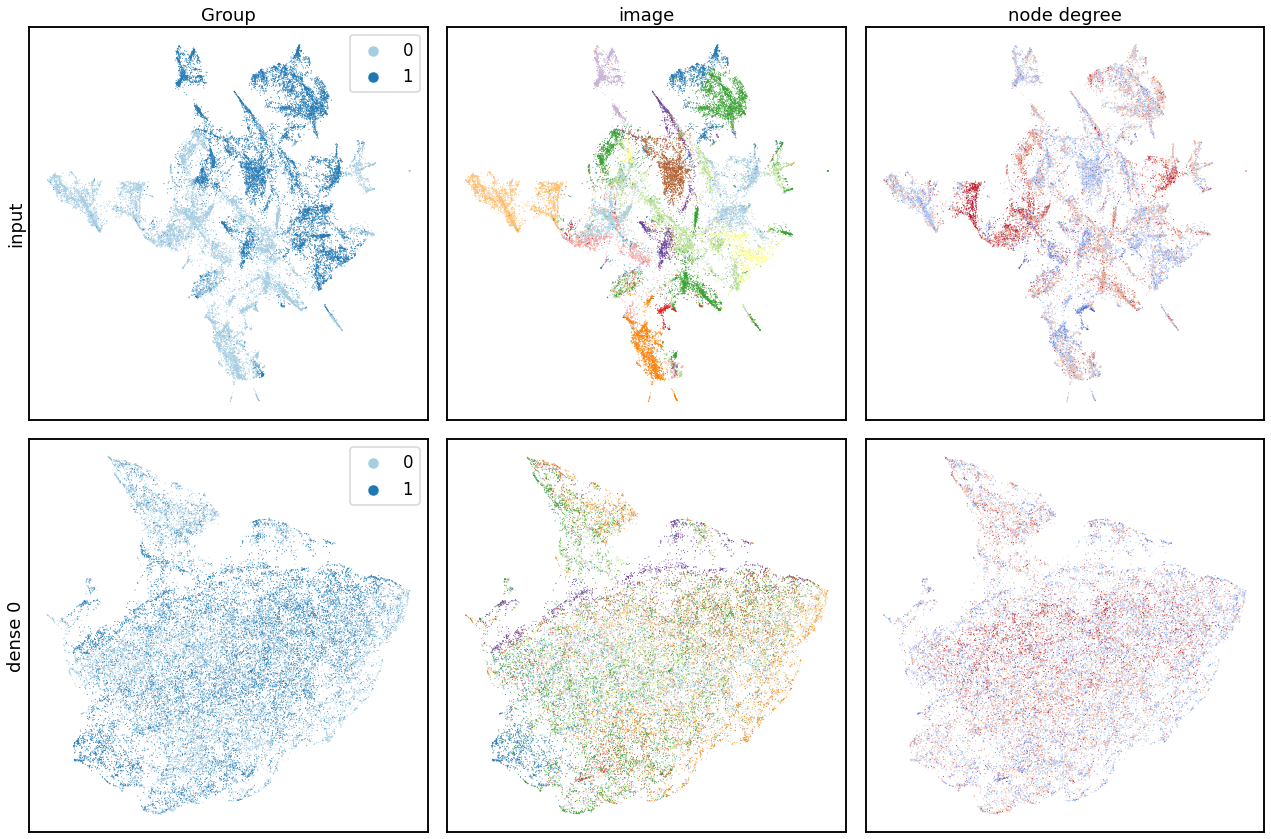

In [43]:
interpreter_mi.plot_umap_nodes(
    interpreter_mi.img_keys_test,
    plot_types = ['Group', 'images', 'degree'],
    layer_names=[
        'input',
        'Layer_dense_feature_embedding0',
    ],
    panel_width=6.0,
    panel_height=6.0,
    data_key='sch',
#     save=dir_figures+"supp_mi_std_node_emb_refactored", 
)

In [37]:
layer_name = 'Layer_dense_feature_embedding0'
acts = interpreter_mi._get_node_embeddings(
        idx=interpreter_mi.img_keys_test,
        layers=[layer_name]
    )
h = acts[layer_name]
cells = np.concatenate(h)
cells = cells[:, cells.std(axis=0) > 0]
cells = (cells - cells.mean(axis=0)) / cells.std(axis=0)


images = np.concatenate([[id] * interpreter_mi.h[id].shape[0] for id in interpreter_mi.img_keys_test])

adata_cells = anndata.AnnData(
    cells,
    obs=pd.DataFrame({
        "images": images,
    })
)

adata_cells.obs['images'] = adata_cells.obs['images'].astype('category')
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
adata_cells.obs['images_label'] = le.fit_transform(adata_cells.obs["images"])


from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(adata_cells.X, adata_cells.obs["images_label"])

print(f"{layer_name=}")
image_score = logreg.score(adata_cells.X, adata_cells.obs["images_label"])
print(f'Images training score: {image_score}')
predict_score_images_cells.append(image_score)



from sklearn.metrics import explained_variance_score, r2_score

explained_variance_score_images = explained_variance_score(adata_cells.obs["images_label"], 
                                                           logreg.predict(adata_cells.X))
print(f'Variance explained - images : {explained_variance_score_images}')
varian_explained_images_cells.append(explained_variance_score_images)

r2_score_images = r2_score(adata_cells.obs["images_label"], 
                           logreg.predict(adata_cells.X), 
                           multioutput='uniform_average')
print(f'R2 score - images: {r2_score_images}')
r2_images_cells.append(r2_score_images)

from scipy import sparse, stats

r2_score_linreg = stats.linregress(adata_cells.obs["images_label"], logreg.predict(adata_cells.X))[2] ** 2
print(f'R2 score linreg - images: {r2_score_linreg}')
r2_linreg_images_cells.append(r2_score_linreg)

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


layer_name='Layer_dense_feature_embedding0'
Images training score: 0.37413369103509947
Variance explained - images : -0.19724004519156635
R2 score - images: -0.2288214738048262
R2 score linreg - images: 0.17459005380088582


In [38]:
sc.pp.neighbors(adata_cells, n_neighbors=n_neighbors)
sc.tl.pca(adata_cells)

label_key="images"
images_metric = scib.metrics.graph_connectivity(adata_cells, label_key=label_key)
graph_connectivity_cells_images.append(images_metric)
print(f'graph connectivity metric {layer_name} layer - {label_key} = {images_metric}')

label_key="images"
images_metric = scib.metrics.ilisi_graph(adata_cells, batch_key=label_key)
ilisi_cells_images.append(images_metric)
print(f'ilisi graph  metric {layer_name} layer - {label_key} = {images_metric}')

graph connectivity metric Layer_dense_feature_embedding0 layer - images = 0.9346012782920832
/tmp/lisi_03vzj58e/input.mtx /tmp/lisi_03vzj58e/
ilisi graph  metric Layer_dense_feature_embedding0 layer - images = 0.19686109306937655


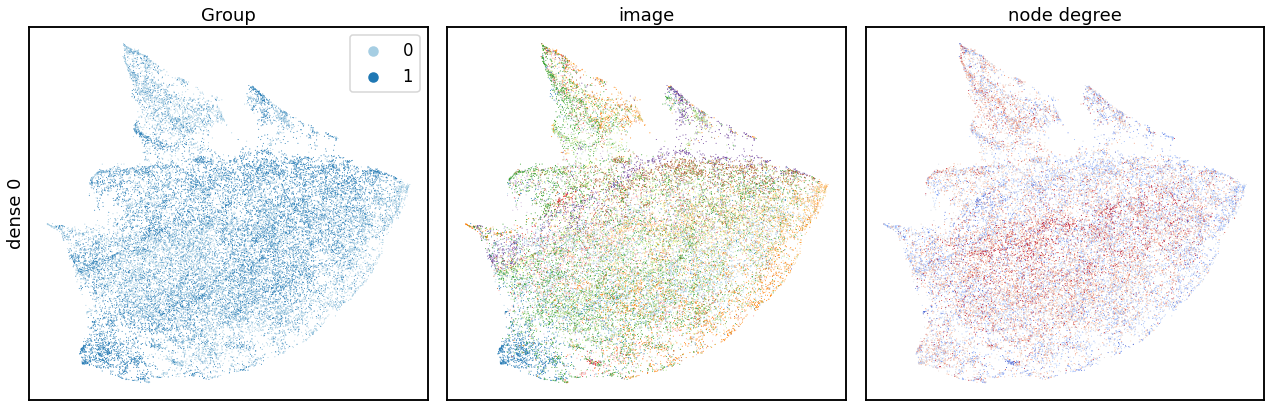

In [39]:
n_neighbors=50
layer_name = 'Layer_dense_feature_embedding0'
umap_emb, hue = interpreter_mi.plot_umap_nodes(
    interpreter_mi.img_keys_test,
    plot_types = ['Group', 'images', 'degree'],
    layer_names=[
        layer_name,
    ],
    panel_width=6.0,
    panel_height=6.0,
    data_key='sch',
    return_embeddings=True,
    n_neighbors=n_neighbors,
)

In [40]:
adata = anndata.AnnData(
    umap_emb,
    obs=pd.DataFrame({
        "images": hue["images"],
        "Group": hue["Group"]
    })
)

adata.obs['images'] = adata.obs['images'].astype('category')
adata.obs['Group'] = adata.obs['Group'].astype('category')
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
adata.obs['images_label'] = le.fit_transform(adata.obs["images"])


sc.pp.neighbors(adata, n_neighbors=n_neighbors)
sc.tl.pca(adata)

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [41]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(adata.X, adata.obs["images_label"])

print(f"{layer_name=}")
image_score = logreg.score(adata.X, adata.obs["images_label"])
print(f'Images training score: {image_score}')
predict_score_images.append(image_score)


from sklearn.linear_model import LogisticRegression
logreg_grade = LogisticRegression()
logreg_grade.fit(adata.X, adata.obs["Group"])

grade_score = logreg_grade.score(adata.X, adata.obs["Group"])
print(f'Group training score: {grade_score}')
predict_score_grade.append(grade_score)


from sklearn.metrics import explained_variance_score, r2_score

explained_variance_score_images = explained_variance_score(adata.obs["images_label"], logreg.predict(adata.X), multioutput='variance_weighted')
print(f'Variance explained - images : {explained_variance_score_images}')
varian_explained_images.append(explained_variance_score_images)

r2_score_images = r2_score(adata.obs["images_label"], logreg.predict(adata.X), multioutput='uniform_average')
print(f'R2 score - images: {r2_score_images}')
r2_images.append(r2_score_images)

from scipy import sparse, stats

r2_score_linreg = stats.linregress(adata.obs["images_label"], logreg.predict(adata.X))[2] ** 2
print(f'R2 score linreg - images: {r2_score_linreg}')
r2_linreg_images.append(r2_score_linreg)

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


layer_name='Layer_dense_feature_embedding0'
Images training score: 0.212161860049184
Group training score: 0.5013786422237126
Variance explained - images : -0.8960480273030369
R2 score - images: -0.9532283731651994
R2 score linreg - images: 0.0007888169713154349


In [42]:
### n=50
label_key="Group"
graph_metric = scib.metrics.graph_connectivity(adata, label_key=label_key)
graph_conn_grade.append(graph_metric)

print(f'graph connectivity metric {layer_name} layer - {label_key} = {graph_metric}')

label_key="images"
images_metric = scib.metrics.graph_connectivity(adata, label_key=label_key)
graph_conn_images.append(images_metric)
print(f'graph connectivity metric {layer_name} layer - {label_key} = {images_metric}')

label_key="Group"
grade_metric = scib.metrics.ilisi_graph(adata, batch_key=label_key)
ilsi_graph_grade.append(grade_metric)
print(f'ilisi graph metric {layer_name} layer - {label_key} = {grade_metric}')

label_key="images"
images_metric = scib.metrics.ilisi_graph(adata, batch_key=label_key)
ilsi_graph_images.append(images_metric)
print(f'ilisi graph  metric {layer_name} layer - {label_key} = {images_metric}')

graph connectivity metric Layer_dense_feature_embedding0 layer - Group = 0.9997710213447717
graph connectivity metric Layer_dense_feature_embedding0 layer - images = 0.5695818235957104
/tmp/lisi_al0qlg5n/input.mtx /tmp/lisi_al0qlg5n/
ilisi graph metric Layer_dense_feature_embedding0 layer - Group = 0.7864828656716039
/tmp/lisi_gggipv41/input.mtx /tmp/lisi_gggipv41/
ilisi graph  metric Layer_dense_feature_embedding0 layer - images = 0.24455492573507723


#### Plot integration metrics

In [108]:
df_metrics_mean = pd.DataFrame(columns=["prediction_score", "variance_explained", "r2_score", "graph_connectivity", "ilisi", "1 - graph_connectivity"])
for model in ["input", "GCNSS", "GCN", "MI"]:
    df_metrics_mean.loc[model] = df_metrics[df_metrics["model"] == model].mean().values
df_metrics_mean.to_csv(dir_figures + "df_metrics_mean.csv")

In [109]:
df_metrics_mean

prediction_score  variance_explained  r2_score  graph_connectivity  \
input          0.966764            0.958810  0.958810            0.991879   
GCNSS          0.760414            0.586973  0.585035            0.918065   
GCN            0.792583            0.662490  0.662050            0.916429   
MI             0.374134           -0.197240 -0.228821            0.934601   

          ilisi  1 - graph_connectivity  
input  0.066433                0.008121  
GCNSS  0.085589                0.081935  
GCN    0.063115                0.083571  
MI     0.196861                0.065399

<Figure size 720x720 with 0 Axes>

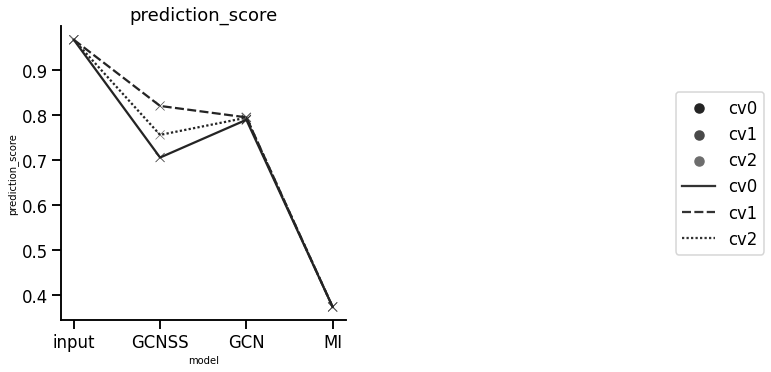

<Figure size 720x720 with 0 Axes>

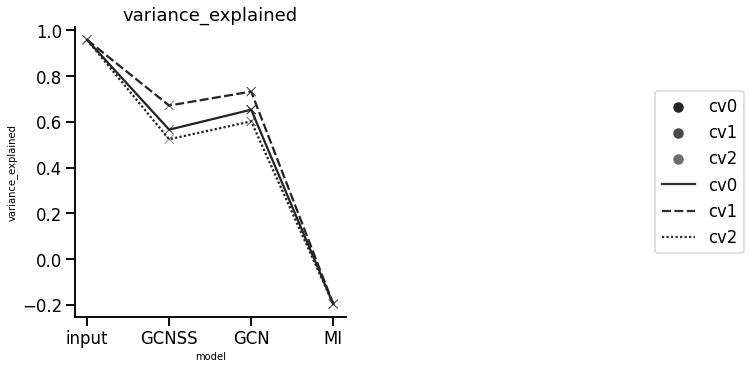

<Figure size 720x720 with 0 Axes>

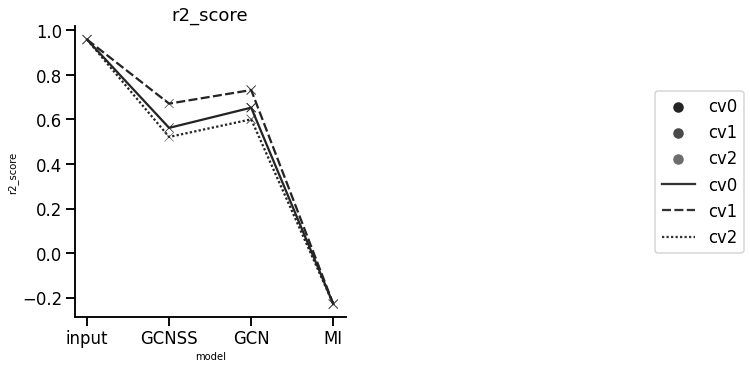

<Figure size 720x720 with 0 Axes>

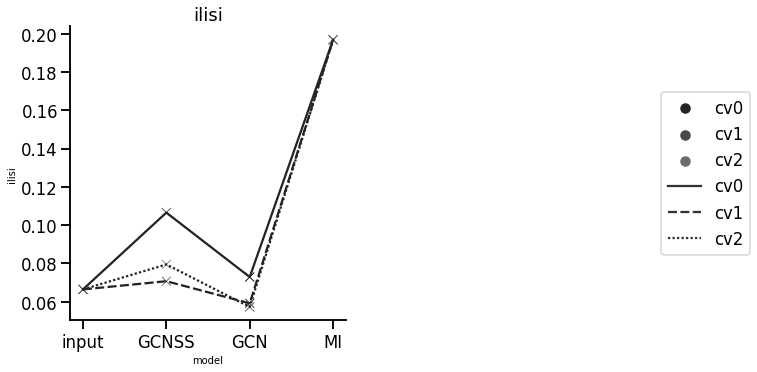

<Figure size 720x720 with 0 Axes>

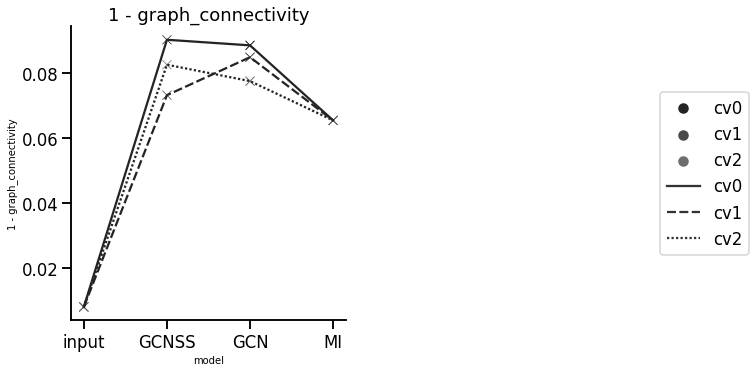

In [104]:
sns.set_palette('gray')

for i, metric in enumerate(["prediction_score","variance_explained","r2_score","ilisi","1 - graph_connectivity"]):
    plt.figure(figsize=(10,10))
    g = sns.FacetGrid(df_metrics, size=5)
    g.map(sns.scatterplot, "model", metric, hue=df_metrics["cv"], marker='x')
    g.map(sns.lineplot, "model", metric, style=df_metrics["cv"], linestyle='--')
    plt.legend(bbox_to_anchor=[2.5, 0.5], loc="right")
    plt.title(metric)
    plt.tight_layout()
    plt.savefig(dir_figures + f"{metric}_cvs.pdf", bbox_inches = "tight")

    plt.show()
